In [238]:
#import necessary modules
import numpy as np
import matplotlib.pyplot as plt
import importlib
from astropy.io import fits
from pathlib import Path

#project modules
import my_mcmc as mcmc
import make_plots as mkp

# Test #1: Fitting simulated 2-D Gaussian Data

### The first step is to generate our data using the generate_data function in the my_mcmc module. We can also create a contour plot to check that it looks how we expect:

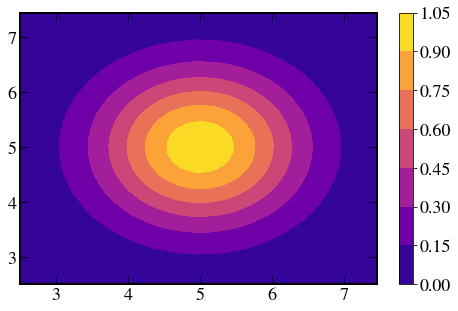

In [240]:
gen_coords, y, x0 = mcmc.generate_data(mcmc.gaussian_2d_ind_gen, npts=100, par=[5,5,1,1,1], sigma=1e-3, upper_bound=7.5, lower_bound=2.5)
#contour plot
fig, ax = mkp.set_plot_params()
CS = ax.contourf(gen_coords[:,:,0], gen_coords[:,:,1], y, cmap='plasma')
fig.colorbar(CS)

### Now set priors and guesses for the parameters that are "reasonable"

In [241]:
#set priors
mins = np.repeat(0,5)
maxes = np.repeat(10,5)

chain length = 5619 MCMC mean = [5.00383875 4.99321583 1.00482151 0.99977478 0.99726465], actual = [5 5 1 1 1]


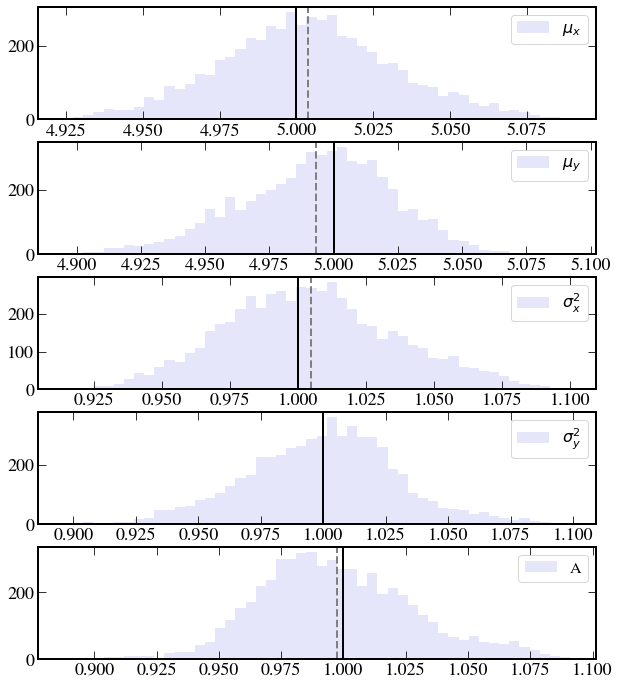

In [242]:
guess = np.array([3.4,4.6,2.3,0.8,2])

xchain = mcmc.run_mcmc(mcmc.gaussian_2d_ind, gen_coords, y, guess, MAX_CHAIN=10000, burn_in=2000, sigma=1, h=.01, mins=mins, maxes=maxes)
print("chain length = {2} MCMC mean = {0}, actual = {1}".format(
      str(np.average(xchain, axis=0)), str(x0), xchain.shape[0]))

#create histograms of parameter values
mkp.param_histograms(xchain, x0, figsize=(10,12))

We can see from the histograms above that the average value (shown by the dashed line) is very close to the true value (shown in black) for most of the parameters.

### We can also check that our choice of burn-in steps was reasonable by checking autocorrelation and time series plots

From the traceplots below, we can see that the series appears stationary (roughly constant mean and variance) and therefore the chain has converged

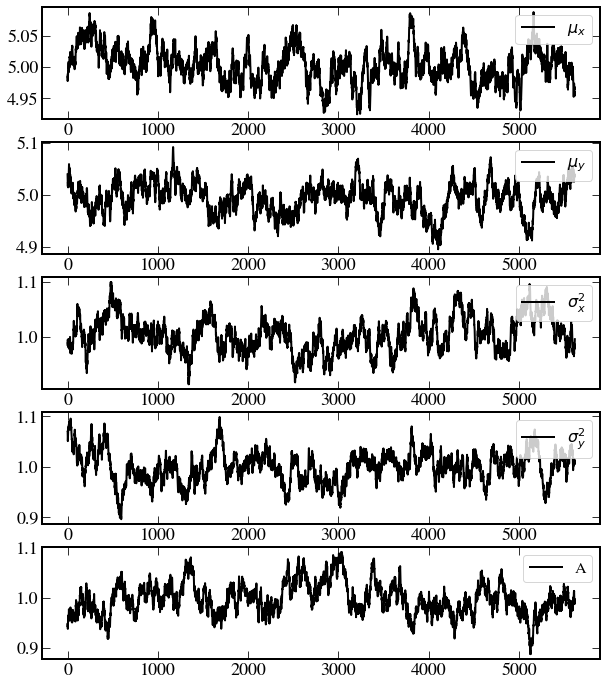

In [243]:
mkp.time_series(xchain, figsize=(10,12))

By modifying the cell below, we can see that after about 10 steps, the chain has not "forgotten" where it started (values are still correlated), but after about 200 steps it has. This indicates our choice of tossing out the first 2000 steps is more than sufficient to ensure the results aren't strongly affected by our initial guess.

In [244]:
print(mcmc.autocorr(xchain, lag=200, nparams=5))
mcmc.autocorr(xchain, lag=2000, nparams=5)

[0.0583297008243843, 0.06892924292407389, 0.13395606925096776, 0.08389791379978746, 0.12009574525739224]


[-0.14443845104505282,
 0.13297993265018482,
 -0.17569202119808663,
 0.06940373377899799,
 0.07295902279635841]

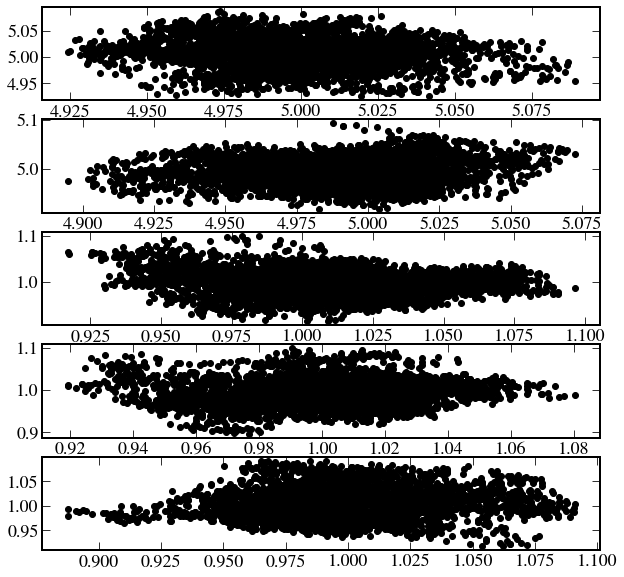

In [245]:
mkp.autocorr(xchain, 2000)

# Test #2: Fitting the 2-D Profile of a Star

In [246]:
filepath = "./2inch_aperture 0.03s exp-0003 copy.fit"

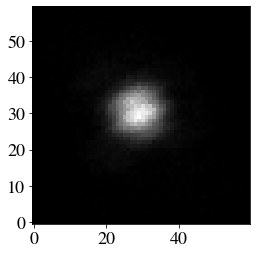

In [247]:
img = fits.getdata(filepath)
# approximate center of the star
x0 = 145
y0 = 213
#zoom in
window_size = 30
img_star = img[y0-window_size:y0+window_size, x0-window_size:x0+window_size]
# plot the zoomed in region
plt.imshow(img_star, origin='lower', cmap='gray')
plt.show()

### Rescaling the image and grabbing the coordinates:

In [248]:
importlib.reload(mcmc)
img = mcmc.process_img(img_star)
t_vals, y_vals, x_vals = mcmc.get_coords(30)

### Set the priors the same way as in the previous test, and make a guess about the parameters:

In [249]:
mins = [25, 25, 0, 0, 0]
maxes = [40, 40, 10, 10, 2*img.max()]

In [250]:
guess = np.array([30,30,4.5,4.5,0])
np.random.seed(52)
xchain = mcmc.run_mcmc(mcmc.gaussian_2d_ind, t_vals, img, guess, MAX_CHAIN=200000, burn_in=10000, sigma=1, h=.001, mins=mins, maxes=maxes)
print("chain length = {1} MCMC mean = {0}".format(
      str(np.average(xchain, axis=0)), xchain.shape[0]))

chain length = 181881 MCMC mean = [3.00524960e+01 3.00002981e+01 4.51397742e+00 4.36559005e+00
 6.67361665e-03]


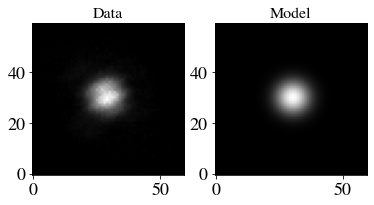

In [252]:
mkp.compare_model(img, xchain, t_vals)

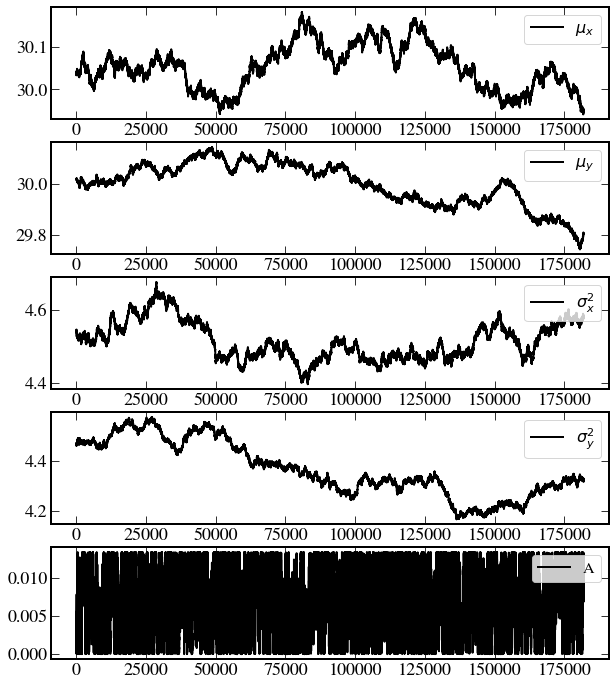

In [253]:
mkp.time_series(xchain)

With the exception of the amplitude (which we imposed restrictive priors on based on the largest value in the data) the chain is not as stationary as for the simulated data in test #1. Judging by the visual appearance of the data compared to the model, the fit is still decent, however, it is important to note that the chain has not converged. Decreasing the step size (h) helps, but at the cost of increased dependence on initial guess and therefore requiring a larger max chain/burn in value.

# Test #3: Fitting a product of trig functions

(Arguably less scientifically motivated but tested in the process of debugging)

## Using a similar approach, we can fit a function of the form:

$sin(x + \phi_{x}) \cdot cos(y + \phi_{y})$

### Again, our first step is to generate data with some noise

In [143]:
importlib.reload(mcmc)

<module 'my_mcmc' from '/Users/oliviamostow/ASTR4470/project/my_mcmc.py'>

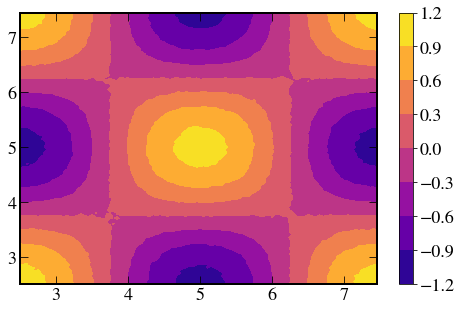

In [260]:
t, y, x0 = mcmc.generate_data(mcmc.trigproduct, 100, par=[np.pi/2, 0], upper_bound=2*np.pi, lower_bound=0, sigma=.01)
fig, ax = mkp.set_plot_params()
CS = ax.contourf(gen_coords[:,:,0], gen_coords[:,:,1], y, cmap='plasma')
fig.colorbar(CS)

### Set priors and initial guess:

In [261]:
mins = [-.5,-.5]
maxes = [2*np.pi, 2*np.pi]
importlib.reload(mkp)

<module 'make_plots' from '/Users/oliviamostow/ASTR4470/project/make_plots.py'>

In [262]:
guess = np.array([np.pi,.2])
xchain = mcmc.run_mcmc(mcmc.trigproduct_v2, t, y, guess, MAX_CHAIN=10000, sigma=5, burn_in=2000, h=.1, mins=mins, maxes=maxes)
print("chain length = {2} MCMC mean = {0}, actual = {1}".format(
      str(np.average(xchain, axis=0)), str(x0), xchain.shape[0]))

chain length = 3863 MCMC mean = [ 1.56929832 -0.00273227], actual = [1.57079633 0.        ]


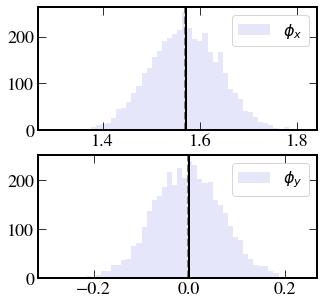

In [263]:
labels = ['$\phi_{x}$', '$\phi_{y}$']
mkp.param_histograms(xchain, x0, labels=labels, nparams=2, figsize=(5,5)) 

# Extension: 2-D Gaussian with nonzero covariance

### Generate data and plot

In [264]:
importlib.reload(mcmc)

<module 'my_mcmc' from '/Users/oliviamostow/ASTR4470/project/my_mcmc.py'>

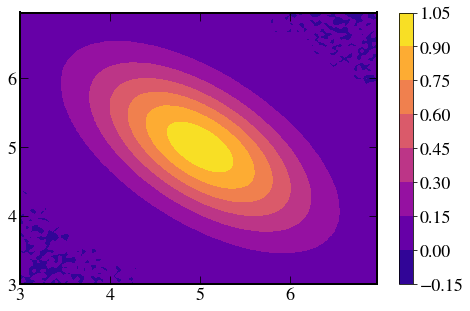

In [327]:
gen_coords, y, x0 = mcmc.generate_data(mcmc.gaussian_2d, npts=100, par=[5,5,1,.5,1,3*np.pi/4], sigma=1e-3, upper_bound=7, lower_bound=3)
#contour plot
fig, ax = mkp.set_plot_params()
CS = ax.contourf(gen_coords[:,:,0], gen_coords[:,:,1], y, cmap='plasma')
fig.colorbar(CS)

chain length = 5358 MCMC mean = [5.00698901 5.00362924 1.00960544 0.50086803 0.99470621 0.52269933], actual = [5.         5.         1.         0.5        1.         0.52359878]


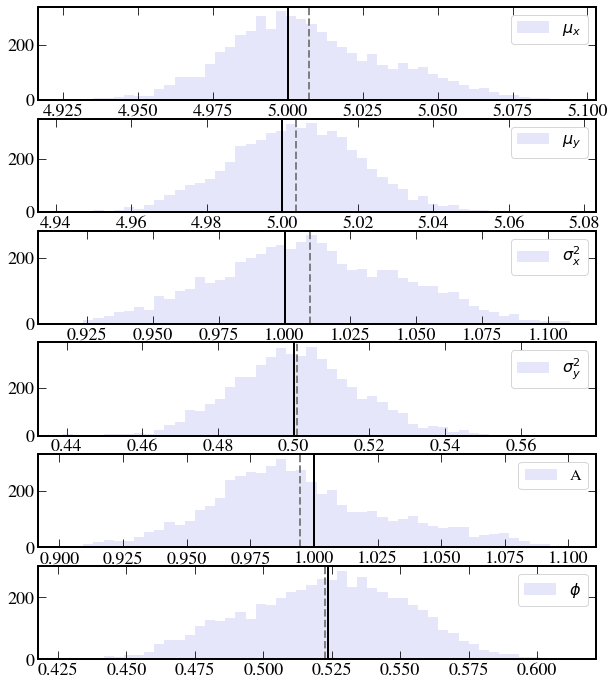

In [292]:
#set priors
mins = np.repeat(0,5)
maxes = np.repeat(10,5)

guess = np.array([5.2,4.5,.6,1,.5,np.pi/3])

xchain = mcmc.run_mcmc(mcmc.gaussian_2d_general, gen_coords, y, guess, MAX_CHAIN=10000, burn_in=2000, sigma=1, h=.01, mins=mins, maxes=maxes)
print("chain length = {2} MCMC mean = {0}, actual = {1}".format(
      str(np.average(xchain, axis=0)), str(x0), xchain.shape[0]))

#create histograms of parameter values
labels = ['$\mu_{x}$','$\mu_{y}$','$\sigma^{2}_{x}$','$\sigma^{2}_{y}$', 'A', '$\phi$']
mkp.param_histograms(xchain, x0, figsize=(10,12), nparams=6, labels=labels)

We can see from the histograms above that the average value (shown by the dashed line) is very close to the true value (shown in black) for most of the parameters.

# Testing this on a real image

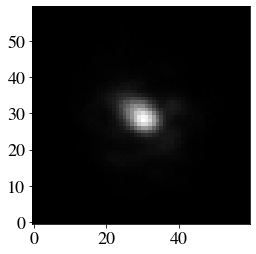

In [295]:
filepath = './3.5inch_aperture 0.03s exp-0005 copy.fit'
img = mcmc.process_img(img_star)
t_vals, y_vals, x_vals = mcmc.get_coords(30)
img = mcmc.process_img(img_star)
t_vals, y_vals, x_vals = mcmc.get_coords(30)
img = fits.getdata(filepath)
# approximate center of the star
x0 = 175
y0 = 185
#zoom in
window_size = 30
img_star = img[y0-window_size:y0+window_size, x0-window_size:x0+window_size]
# plot the zoomed in region
plt.imshow(img_star, origin='lower', cmap='gray')
plt.show()

In [296]:
importlib.reload(mcmc)
img = mcmc.process_img(img_star)
t_vals, y_vals, x_vals = mcmc.get_coords(30)

In [398]:
mins = [25, 25, 0, 0, 0, 0]
maxes = [40, 40, 10, 10, 2*img.max(), 2*np.pi]
importlib.reload(mkp)

<module 'make_plots' from '/Users/oliviamostow/ASTR4470/project/make_plots.py'>

In [423]:
guess = np.array([30,30,3,2.5,0,5*np.pi/6])
np.random.seed(1007)
xchain = mcmc.run_mcmc(mcmc.gaussian_2d_general, t_vals, img, guess, MAX_CHAIN=100000, burn_in=10000, sigma=.1, h=.001, mins=mins, maxes=maxes)
print("chain length = {1} MCMC mean = {0}".format(
      str(np.average(xchain, axis=0)), xchain.shape[0]))

chain length = 87532 MCMC mean = [2.98592191e+01 2.99884289e+01 2.89744229e+00 2.38765292e+00
 1.12165682e-02 2.49385466e+00]


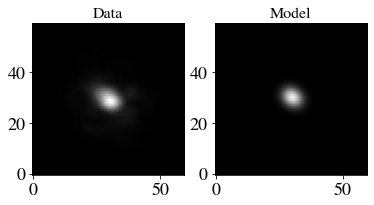

In [424]:
mkp.compare_model(img, xchain, t_vals, mcmc.gaussian_2d_general)

The model can produce a decent fit, however, the answer is not very consistent (in terms of changing the random seed). The results also depend on the initial guess fairly strongly, and if the step size is taken to be larger the parameter estimates get worse.